#  Contextual Bandit (CB) 

In the contextual bandit problem, a learner repeatedly observes a context, chooses an action, and observes a loss/cost/reward exclusively for the action it picked. Contextual bandit algorithms use additional side information (or context) to aid real world decision-making. They work well for choosing actions in dynamic environments where options change rapidly, and the set of available actions is limited.

<b> Requirements</b>

vowpalwabbit==9.8.0
<br>torch=1.13.1

In [1]:
import vowpalwabbit
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

### Define problem parameters

In [2]:
# Shared Context
shared_contexts = ['city', 'interstate']

# Action Options
size_types = ['small', 'medium', 'large']
engine_types = ['petrol', 'diesel', 'electric']
tire_types = ['all_season', 'snow', 'performance', 'all_terrain']

### Reward function

In [3]:
def reward_function(shared_context, size_index, engine_index, tire_index):
    size_value = [0.8, 1.0, 0.9] # Higher value indicates better fuel efficiency
    engine_value = [0.7, 0.9, 1.0] # Higher value indicates better performance
    tire_value = [0.9, 0.8, 1.0, 0.95] # Higher value indicates better comfort

    reward = (
        size_value[size_index]
        * engine_value[engine_index]
        * tire_value[tire_index]
    )

    # Add noise to the reward, representing uncertainties in weather, road conditions, and so on. 
    noise_scale = 0.05
    noise_value = np.random.normal(loc=0, scale=noise_scale)
    reward += noise_value

    return reward

### Generate combinations

In [4]:
def generate_combinations(shared_context, size_types, engine_types, tire_types):
    examples = [f"shared |User {shared_context}"]
    descriptions = []
    for i, size in enumerate(size_types):
        for j, engine in enumerate(engine_types):
            for k, tire in enumerate(tire_types):
                examples.append(f"|Action truck_size={size} engine={engine} tire={tire}")
                descriptions.append((i, j, k))
    return examples, descriptions

### Sample delivery trucks using a probability mass function (PMF)

In [5]:
def sample_truck_pmf(pmf):
    pmf_tensor = torch.tensor(pmf)
    index = torch.multinomial(pmf_tensor, 1).item()
    chosen_prob = pmf[index]
    
    return index, chosen_prob

## This is an alternative implementation of the sample_truck_pmf function without using PyTorch.
# def sample_truck_pmf(pmf):
#     pmf = np.array(pmf)
#     pmf /= np.sum(pmf)
#     indices = np.arange(len(pmf))

#     chosen_index = np.random.choice(indices, p=pmf)
#     chosen_prob = pmf[chosen_index]

#     return chosen_index, chosen_prob

### Create a contexual bandit

Vowpal Wabbit offers five exploration algorithms:

Explore-First: --first

Epsilon-Greedy: --epsilon

Bagging Explorer: --bag

Online Cover: --cover

Softmax Explorer: --softmax (only supported for --cb_explore_adf)

In [6]:
cb_vw = vowpalwabbit.Workspace(
    "--cb_explore_adf --epsilon 0.2 --interactions AA AU AAU -l 0.05 --power_t 0",
    quiet=True,
)

### Training loop

In [7]:
num_iterations = 2500
cb_rewards = []
with tqdm(total=num_iterations, desc="Training") as pbar:
    for _ in range(num_iterations):
        shared_context = random.choice(shared_contexts)
        examples, indices = generate_combinations(
            shared_context, size_types, engine_types, tire_types
        )
        cb_prediction = cb_vw.predict(examples)
        chosen_index, prob = sample_truck_pmf(cb_prediction)
        size_index, engine_index, tire_index = indices[chosen_index]
        reward = reward_function(shared_context, size_index, engine_index, tire_index)
        cb_rewards.append(reward)
        examples[chosen_index + 1] = f"0:{-1*reward}:{prob} {examples[chosen_index + 1]}"
        cb_vw.learn(examples)
        pbar.set_postfix({'Reward': reward})
        pbar.update(1)
cb_vw.finish()

Training:   1%|▏         | 34/2500 [00:00<00:15, 154.91it/s, Reward=0.919]

Training: 100%|██████████| 2500/2500 [00:12<00:00, 204.48it/s, Reward=0.984]


### Plot the average reward

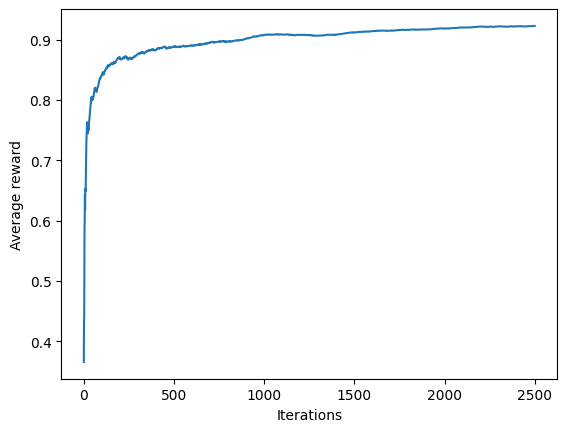

In [8]:
plt.plot(pd.Series(cb_rewards).expanding().mean())
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.show()

### Use trained model to perform predictions on a test set

In [9]:
def test_model(shared_context, size_types, engine_types, tire_types):
    examples, indices = generate_combinations(shared_context, size_types, engine_types, tire_types)
    cb_prediction = cb_vw.predict(examples)
    chosen_index, prob = sample_truck_pmf(cb_prediction)
    chosen_action = examples[chosen_index + 1]
    size_index, engine_index, tire_index = indices[chosen_index]
    expected_reward = reward_function(shared_context, size_index, engine_index, tire_index)
    print("Chosen Action:", chosen_action)
    print("Expected Reward:", expected_reward)

# Test the model for a given shared context
test_shared_context = 'city'
test_model(test_shared_context, size_types, engine_types, tire_types)

Chosen Action: |Action truck_size=medium engine=electric tire=performance
Expected Reward: 1.012098801128327


<i>Note</i>: maximum reward with noise≈1.0+0.15=1.15